In [20]:
import warnings

# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import scanpy as sc
import scvi
import scib

# Set global matplotlib figure size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [21]:
adata = sc.read_h5ad("1_qc.h5ad")
adata

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


AnnData object with n_obs × n_vars = 7351 × 27451
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'scrublet'
    layers: 'ambiguous', 'count', 'log1p', 'spliced', 'unspliced'

In [22]:
# Specify which colorings to use for plotting
umap_colorings = [
    "sample",
    "cell_type",
]

# Data preparation

In [23]:
# For now, we ignore RR cells
# They have a different gene expression profile
# Not sure how to deal with them yet (and what we want to learn from them)
adata = adata[~adata.obs["is_rr"]].copy()

# Identify highly variable genes
# Using 5000 genes for now, can be adjusted
sc.pp.highly_variable_genes(adata, n_top_genes=5000, batch_key="sample", layer="log1p")
adata_hvg = adata[:, adata.var.highly_variable].copy()

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Looking at the uncorrected data distributions

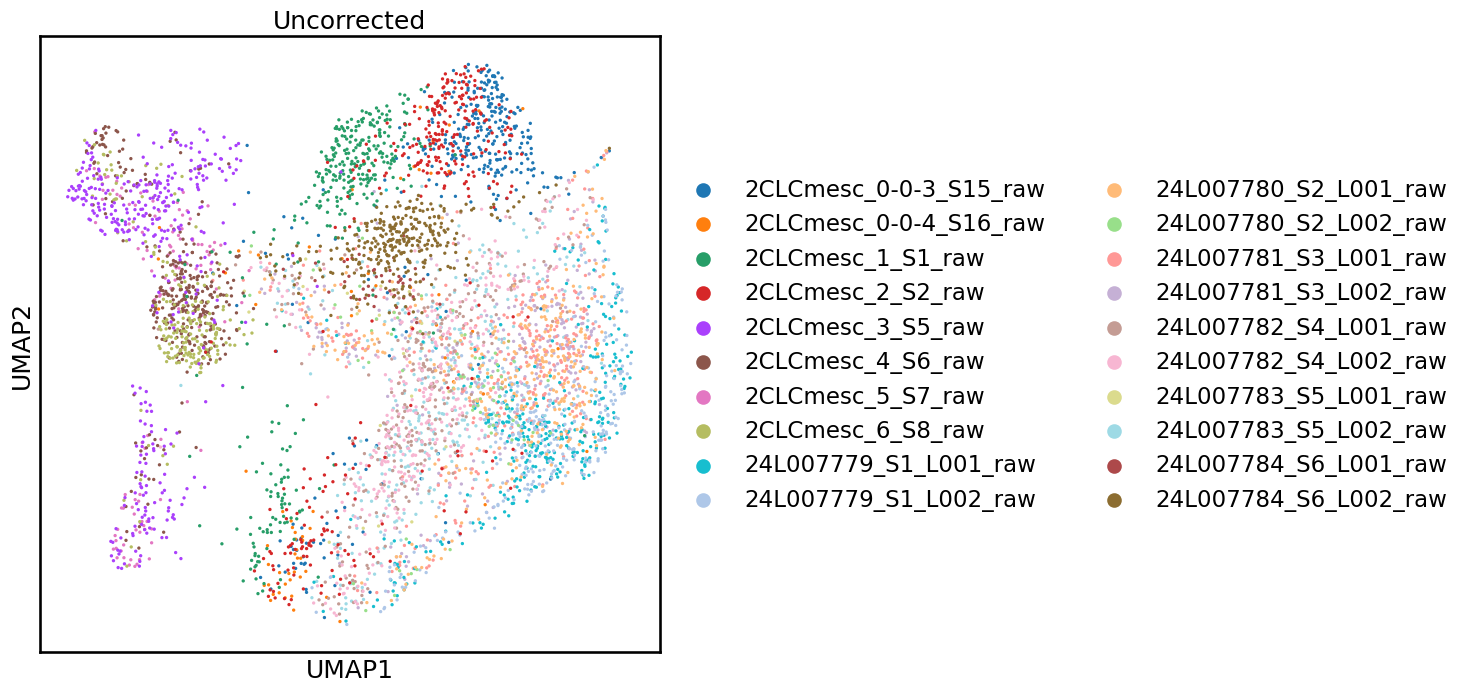

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


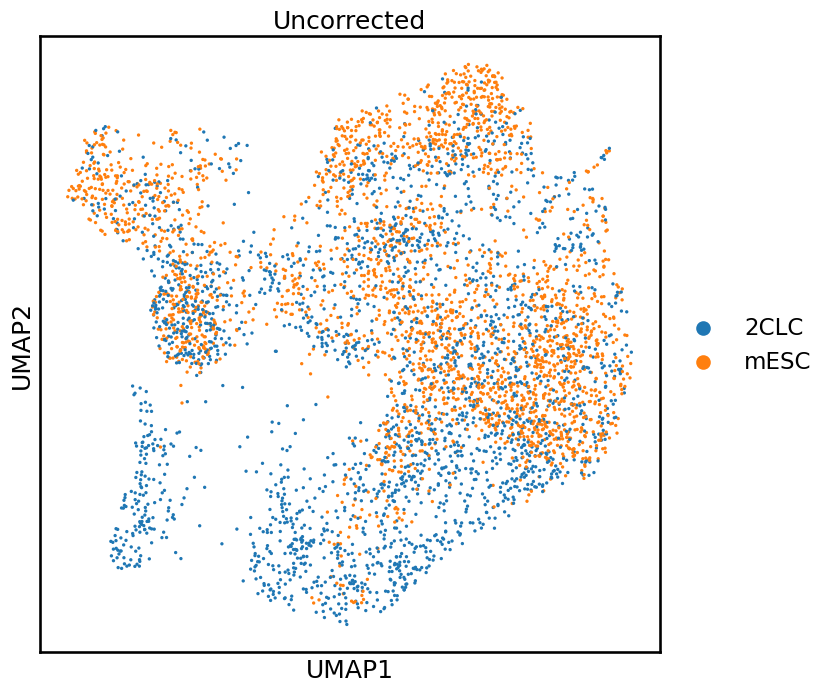

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
sc.pp.pca(adata, n_comps=50, layer="log1p")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
for coloring in umap_colorings:
    sc.pl.umap(adata, color=coloring, title="Uncorrected")

We can see that the samples form clusters in the UMAP. This indicates that the batch effects are not negligible.
We can also see that the cell types separate in the UMAP. 
Biological signal and batch effects appear to be of similar strength in this data.

# Integration

Batch correction is referred to as integration in the single-cell literature. This is, because the count matrices are too large for performing actual batch correction. Instead, the data is integrated into a lower-dimensional space, where the batch effects are removed.

## scVI

scVI uses a variational Autoencoder to integrate the data. The encoder learns a lower-dimensional representation of the data, while the decoder learns to reconstruct the data from this representation.

In [6]:
# Create and train the model
scvi.model.SCVI.setup_anndata(adata_hvg, batch_key="sample", layer="count")
model = scvi.model.SCVI(adata_hvg)
model.train(max_epochs=400, accelerator='cuda')

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/ .

Training:   0%|          | 0/400 [00:00<?, ?it/s]

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.d

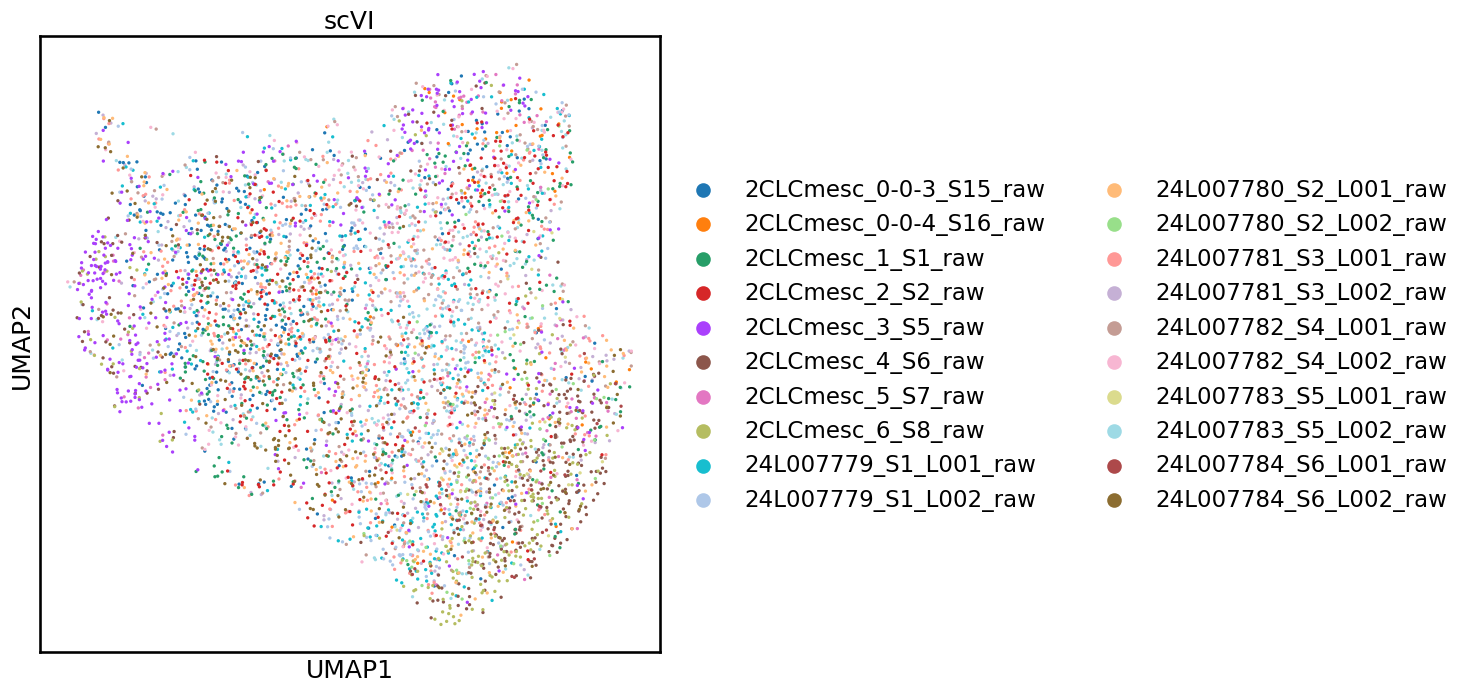

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


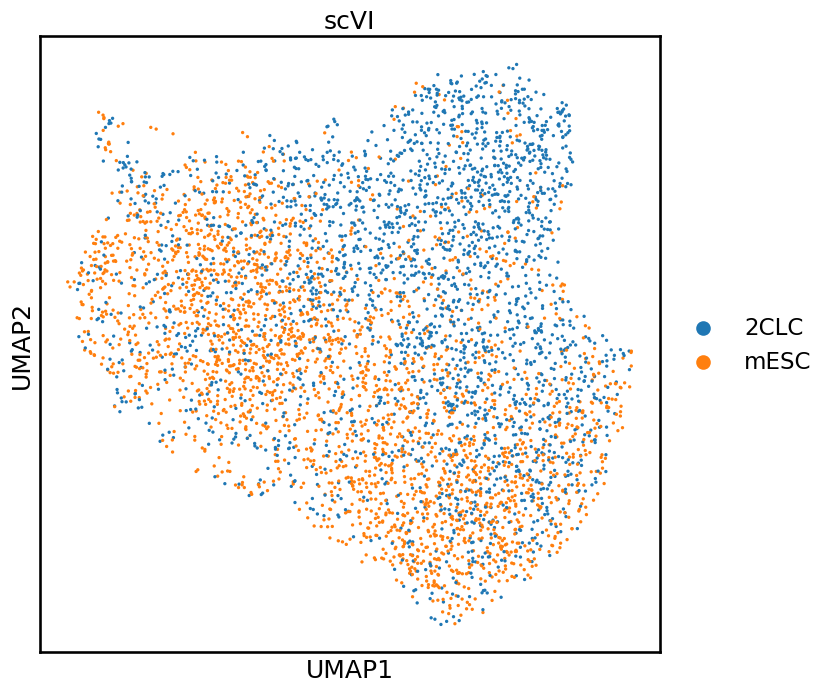

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
# Extract the latent space and store it in the anndata object
adata.obsm["X_scvi"] = model.get_latent_representation()

# Plot the UMAP based on the scVI latent space
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)

for coloring in umap_colorings:
    sc.pl.umap(
        adata,
        color=coloring,
        title="scVI"
    )

While the cell types still separate in the UMAP, the batch effects are removed. This indicates that scVI has successfully integrated the data.
However it looks overcorrected, as subpopulations are not as clearly separated as in the uncorrected data.

In [8]:
# Save the UMAP coordinates to a permanent location
adata.obsm["X_umap_scvi"] = adata.obsm["X_umap"].copy()

## Harmony

Harmony receives a PCA representation of the data and removes the batch effects from there.
Benchmarks have shown that Harmony is one of the best batch correction methods for single-cell data.

In [9]:
# Usually converges after 10-20 iterations
sc.external.pp.harmony_integrate(adata, "sample", max_iter_harmony=50)

2025-01-15 16:20:44,981 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-01-15 16:20:45,471 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-15 16:20:45,493 - harmonypy - INFO - Iteration 1 of 50
2025-01-15 16:20:46,757 - harmonypy - INFO - Iteration 2 of 50
2025-01-15 16:20:48,429 - harmonypy - INFO - Iteration 3 of 50
2025-01-15

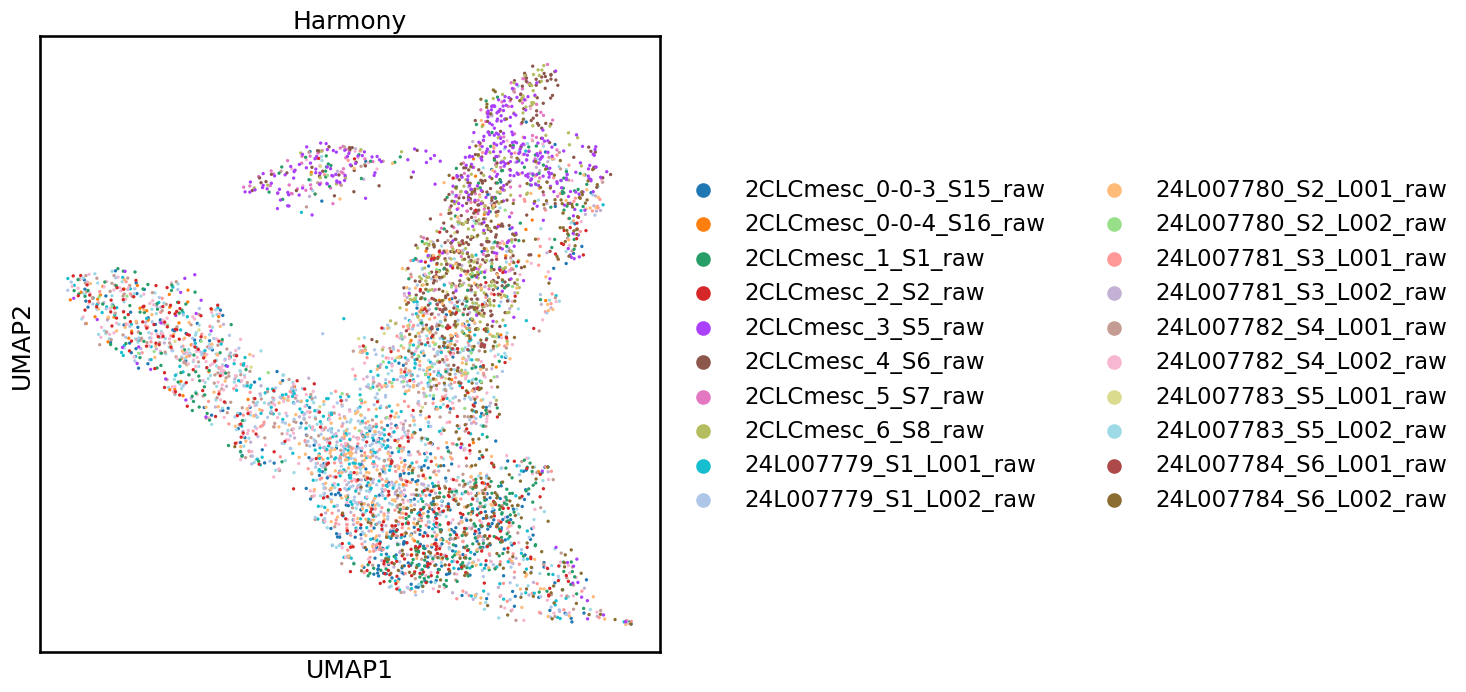

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


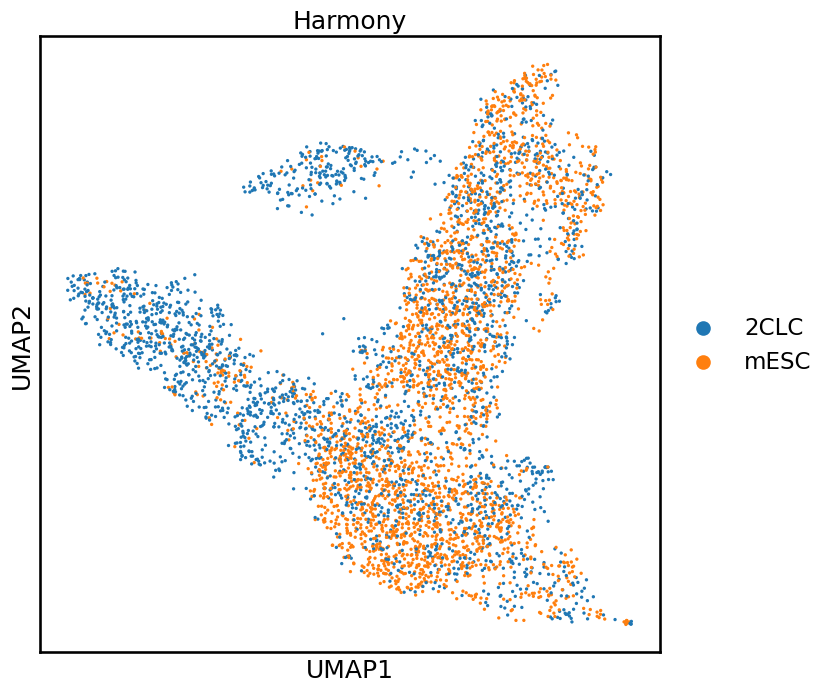

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
# Again, plot the UMAP based on the batch-corrected PCA computed by Harmony
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)

for coloring in umap_colorings:
    sc.pl.umap(
        adata,
        color=coloring,
        title="Harmony"
    )

Here, cell types also separate in the UMAP. Some samples are still clustered, but the batch effects are mostly removed.
This is probably a good compromise between removing batch effects and keeping the biological signal.

In [11]:
# Save the UMAP coordinates to a permanent location
adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"].copy()

# Integration benchmarking using scIB

In [12]:
embeddings = ["X_scvi", "X_pca_harmony"]

results = []

for embedding in embeddings:
    result = scib.me.metrics(adata.raw.to_adata(),
        adata,
        "sample",
        "cell_type",
        embed=embedding,
        organism='mouse',
        ari_=True,
        nmi_=True,
        silhouette_=True,
        pcr_=False,
        cell_cycle_=False,
        hvg_score_=False,
        isolated_labels_=True,
        graph_conn_=True,
        trajectory_=False,
        kBET_=False,
        lisi_graph_=True
    )

    result.columns = [embedding]
    results.append(result)

Recompute neighbors on rep X_scvi instead of X_pca_harmony
Cluster for cluster_0.2 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_0.4 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_0.6 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_0.8 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_1.0 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_1.2 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_1.4 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_1.6 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_1.8 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Cluster for cluster_2.0 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


NMI...
ARI...
Silhouette score...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Isolated labels F1...
Isolated labels ASW...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:186: UserWarning: iso_threshold is equal to number of batches in data, no isolated labels will be found
  isolated_labels = get_isolated_labels(
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

Graph connectivity...
cLISI score...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/lisi.py:172: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a

iLISI score...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_0.2 in adata.obs
  call_cluster_function(


Recompute neighbors on rep X_pca_harmony instead of X_scvi
Cluster for cluster_0.2 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_0.4 in adata.obs
  call_cluster_function(


Cluster for cluster_0.4 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_0.6 in adata.obs
  call_cluster_function(


Cluster for cluster_0.6 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_0.8 in adata.obs
  call_cluster_function(


Cluster for cluster_0.8 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_1.0 in adata.obs
  call_cluster_function(


Cluster for cluster_1.0 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_1.2 in adata.obs
  call_cluster_function(


Cluster for cluster_1.2 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_1.4 in adata.obs
  call_cluster_function(


Cluster for cluster_1.4 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_1.6 in adata.obs
  call_cluster_function(


Cluster for cluster_1.6 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_1.8 in adata.obs
  call_cluster_function(


Cluster for cluster_1.8 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/clustering.py:123: UserWarning: Overwriting existing key cluster_2.0 in adata.obs
  call_cluster_function(


Cluster for cluster_2.0 with leiden


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/metrics.py:293: UserWarning: Overwriting existing key cluster in adata.obs
  res_max, nmi_max, nmi_all = cluster_optimal_resolution(


NMI...
ARI...
Silhouette score...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Isolated labels F1...
Isolated labels ASW...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:186: UserWarning: iso_threshold is equal to number of batches in data, no isolated labels will be found
  isolated_labels = get_isolated_labels(
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

Graph connectivity...
cLISI score...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scib/metrics/lisi.py:172: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a

iLISI score...


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<Axes: >

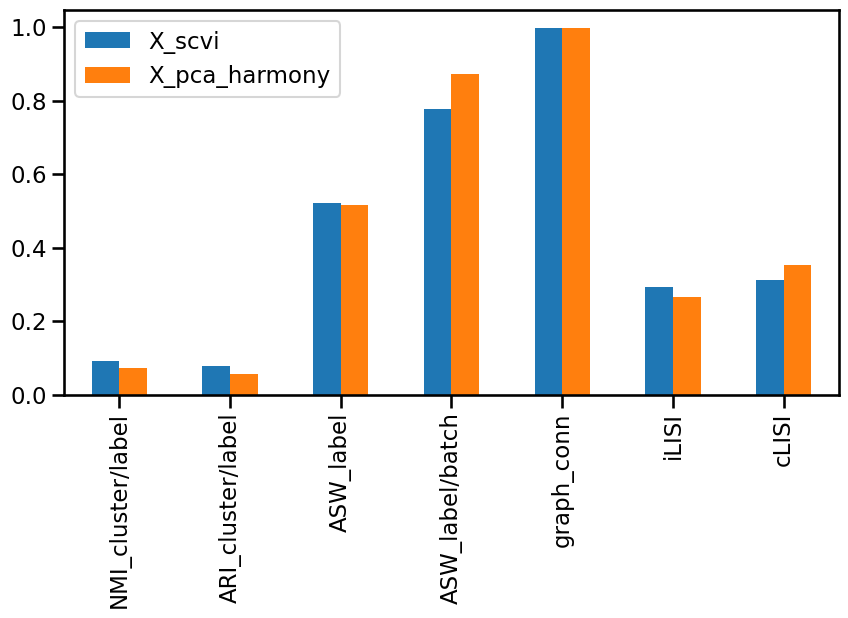

In [ ]:
df_scib = pd.concat(results, axis=1)
df_scib.dropna(axis=0, how='all', inplace=True)
df_scib.plot(kind='bar', figsize=(10, 5))

# Save the data

In [14]:
adata

AnnData object with n_obs × n_vars = 5195 × 27451
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'cluster_0.2', 'cluster_0.4', 'cluster_0.6', 'cluster_0.8', 'cluster_1.0', 'cluster_1.2', 'cluster_1.4', 'cluster_1.6', 'cluster_1.8', 'cluster_2.0', 'cluster', 'silhouette_temp'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'scrublet

In [15]:
adata.write("2_integrate.h5ad")

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
